Develop a multi-layer perceptron with three hidden layers (you pick the dimensions of the hidden layers) for the CIFAR-10 dataset.

1.a. Train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. Report and plot your training and validation results. Report precision, recall, F1 score, and confusion matrix. (25pt)5pt)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import random
import numpy as np


In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [30]:
sample_image, sample_label = train_dataset[0]
print("image size :", sample_image.size())
print(sample_label)

image size : torch.Size([3, 32, 32])
6


In [31]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [32]:
class CIFAR10(nn.Module):
    def __init__(self):
        super(CIFAR10, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 128)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Epoch 1/20, Training Loss: 1.791723184378118, Evaluation Loss: 1.6268851631365644
Epoch 2/20, Training Loss: 1.580732457392199, Evaluation Loss: 1.5339308059253631
Epoch 3/20, Training Loss: 1.4989095433583568, Evaluation Loss: 1.5059367921024847
Epoch 4/20, Training Loss: 1.441958322062831, Evaluation Loss: 1.4558652231868463
Epoch 5/20, Training Loss: 1.3923681389423646, Evaluation Loss: 1.4318933290795397
Epoch 6/20, Training Loss: 1.3490325712044118, Evaluation Loss: 1.4114901073062762
Epoch 7/20, Training Loss: 1.3121003296157143, Evaluation Loss: 1.3996996896716352
Epoch 8/20, Training Loss: 1.2789160766741898, Evaluation Loss: 1.3764699655599868
Epoch 9/20, Training Loss: 1.2494653617428115, Evaluation Loss: 1.375373428621993
Epoch 10/20, Training Loss: 1.2216649118784675, Evaluation Loss: 1.3968605757140504
Epoch 11/20, Training Loss: 1.1962710485501085, Evaluation Loss: 1.3654045841564386
Epoch 12/20, Training Loss: 1.1724790425080942, Evaluation Loss: 1.3656157095211383
Epoch

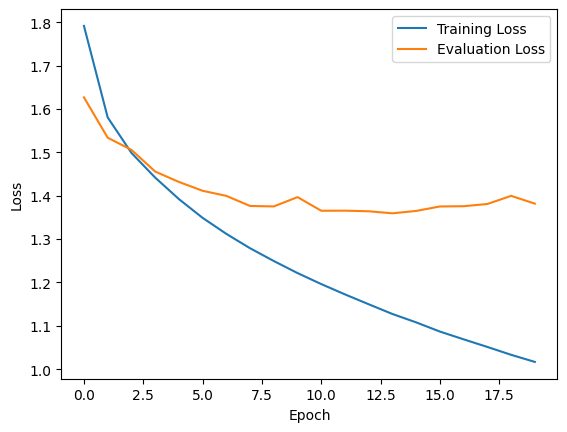

In [34]:
model = CIFAR10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 20

# Lists to store training and evaluation loss for each epoch
train_losses = []
eval_losses = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        training_total += targets.size(0)
        training_correct += (predicted == targets).sum().item()
        train_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    training_accuracy.append(training_correct / training_total)

    # Validation loop (assuming you have a validation set)
    model.eval()
    eval_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
            loss = criterion(outputs, targets)
            eval_loss += loss.item()

    # Average evaluation loss for the epoch
    avg_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)
    validation_accuracy.append(val_correct / val_total)

    # Print training and evaluation progress
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Evaluation Loss: {avg_eval_loss}')

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

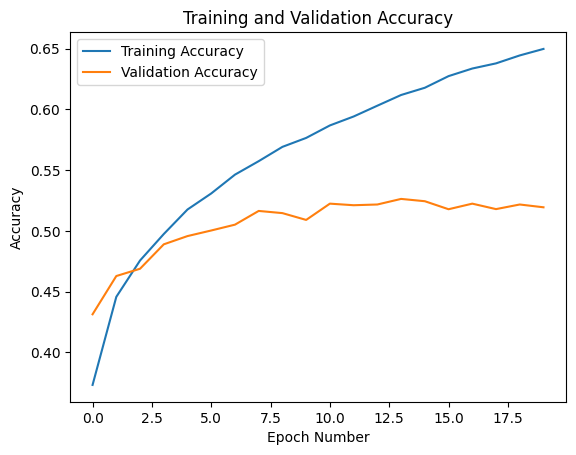

In [35]:
plt.plot( training_accuracy, label='Training Accuracy')
plt.plot( validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend()


In [36]:
torch.save(model.state_dict(), 'cifar10_model.pth')


In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model = CIFAR10().to(device)
model.load_state_dict(torch.load('cifar10_model.pth'))
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Calculate precision, recall, and F1 score
report = classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)])

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_preds)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[560  28  44  21  32  14  27  56 170  48]
 [ 48 595  28  15  12  17  30  21  89 145]
 [ 75  12 374  72 135  96 122  72  31  11]
 [ 36  22  71 300  62 231 145  55  31  47]
 [ 42  12 114  50 417  71 157  94  30  13]
 [ 20  11  76 176  64 445  89  73  21  25]
 [ 14  16  69  67  76  53 655  12  19  19]
 [ 29   7  44  51  97  97  30 592  15  38]
 [ 83  51  24  23  22  17  12  15 697  56]
 [ 47 130  13  41  13  29  29  52  87 559]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      1000
           1       0.67      0.59      0.63      1000
           2       0.44      0.37      0.40      1000
           3       0.37      0.30      0.33      1000
           4       0.45      0.42      0.43      1000
           5       0.42      0.45      0.43      1000
           6       0.51      0.66      0.57      1000
           7       0.57      0.59      0.58      1000
           8       0.59      0.70      0

1.b. Explore the complexity of the network by increasing its width and depth. How do the training and validation results change? Compare them against the baseline. Do you see any overfitting? (25pt)

In [17]:
class Depth_CIFAR10(nn.Module):
    def __init__(self):
        super(Depth_CIFAR10, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 512)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

Epoch 1/20, Training Loss: 1.8885087747262672, Evaluation Loss: 1.6805808974531131
Epoch 2/20, Training Loss: 1.6106995110777198, Evaluation Loss: 1.5456500731337184
Epoch 3/20, Training Loss: 1.496665620300454, Evaluation Loss: 1.4704773944025984
Epoch 4/20, Training Loss: 1.4121725846008086, Evaluation Loss: 1.411759213517649
Epoch 5/20, Training Loss: 1.3425551039701231, Evaluation Loss: 1.3825347613983643
Epoch 6/20, Training Loss: 1.282351064819292, Evaluation Loss: 1.3606427947934063
Epoch 7/20, Training Loss: 1.231553942212979, Evaluation Loss: 1.3646157450569323
Epoch 8/20, Training Loss: 1.1813938196317095, Evaluation Loss: 1.3343236914838845
Epoch 9/20, Training Loss: 1.1369138652517181, Evaluation Loss: 1.3260683407798743
Epoch 10/20, Training Loss: 1.0930993500536859, Evaluation Loss: 1.3563744606682286
Epoch 11/20, Training Loss: 1.0524350929855157, Evaluation Loss: 1.3250224158025017
Epoch 12/20, Training Loss: 1.010975322697457, Evaluation Loss: 1.349697989777635
Epoch 1

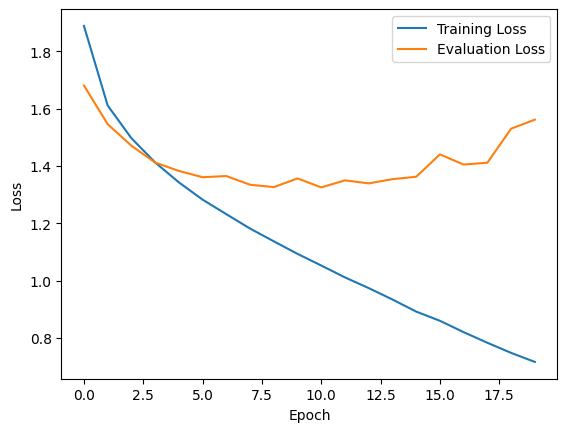

In [24]:
model = Depth_CIFAR10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 20

# Lists to store training and evaluation loss for each epoch
train_losses = []
eval_losses = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    training_correct = 0
    training_total = 0

    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        training_total += targets.size(0)
        training_correct += (predicted == targets).sum().item()
        train_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    training_accuracy.append(training_correct / training_total)

    # Validation loop (assuming you have a validation set)
    model.eval()
    eval_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
            loss = criterion(outputs, targets)
            eval_loss += loss.item()

    # Average evaluation loss for the epoch
    avg_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)
    validation_accuracy.append(val_correct / val_total)

    # Print training and evaluation progress
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Evaluation Loss: {avg_eval_loss}')

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

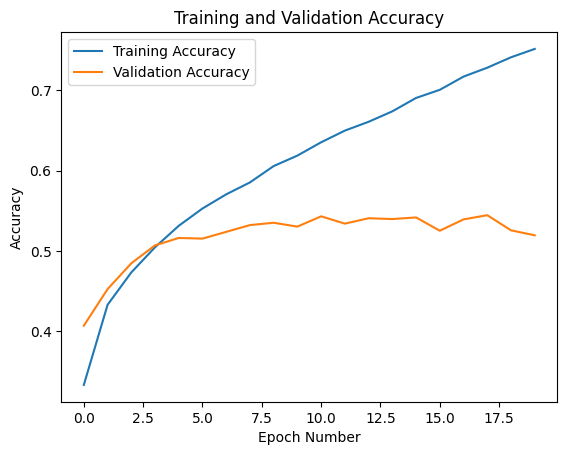

In [25]:
plt.plot( training_accuracy, label='Training Accuracy')
plt.plot( validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend()


In [26]:
torch.save(model.state_dict(), 'depth_cifar10_model.pth')


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
model = Depth_CIFAR10().to(device)
model.load_state_dict(torch.load('depth_cifar10_model.pth'))
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Calculate precision, recall, and F1 score
report = classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)])

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[542  17  57  74  34  13  16  13 184  50]
 [ 61 535  14  45  11  11  10  14 143 156]
 [ 80  11 460 135  98  81  50  36  24  25]
 [ 21  15  94 487  56 156  75  39  23  34]
 [ 51   2 163  94 467  60  61  53  29  20]
 [ 15   5  69 311  67 391  46  50  25  21]
 [ 24  12  97 155  97  49 518  11  16  21]
 [ 32   9  64 126  74  94  14 519  23  45]
 [ 69  39  13  50  15  10   6   5 761  32]
 [ 32 118  20  81   8  27  21  19 159 515]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56      1000
           1       0.70      0.54      0.61      1000
           2       0.44      0.46      0.45      1000
           3       0.31      0.49      0.38      1000
           4       0.50      0.47      0.48      1000
           5       0.44      0.39      0.41      1000
           6       0.63      0.52      0.57      1000
           7       0.68      0.52      0.59      1000
           8       0.55      0.76      0